# Neural Machine Translation using Seq2Seq Models

In HW06, we will be training our own machine translation system. We will use an LSTM encoder decoder model and train it with Pytorch.

Make sure you are using a GPU. Go to Runtime -> Change Runtime Type -> GPU.

In [ ]:
!pip install sacrebleu sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will use the TED 2013 English-Mandarin parralel dataset. We have done some cleaning and preprocessing for you. We have also created the train, dev, and test splits. Upload the data from the handout and unzip the file.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip /content/drive/MyDrive/nlp_hw6/data.zip

Import the libraries we will use. After running the cell below, if your notebook is configured to run on GPU, you should see a `device(type='cuda')` output

In [ ]:
import operator
import os
import pickle
import random
import re
import string
import unicodedata

import numpy as np
import sentencepiece as spm
import torch
import torch.nn.functional as F
from sacrebleu.metrics import BLEU, CHRF
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(device)
print(f"Device being used: {device}")

Device being used: cuda


## Preprocessing and Tokenization

We will use Sentencepiece to train BPE tokenization models for both the source and target languages.


Define a function to load the dataset.

In [ ]:
def load_dataset(lang1, lang2, max_length=10, root="data", split="train"):
    ipt1 = os.path.join(root, ".".join([split, lang1]))
    ipt2 = os.path.join(root, ".".join([split, lang2]))
    corpus = {lang1: [], lang2: []}
    with open(ipt1) as f1, open(ipt2) as f2:
        for sent1, sent2 in zip(f1, f2):
            clean1 = sent1.strip()
            clean2 = sent2.strip()
            if len(clean1) == 0 or len(clean2) == 0:
                continue
            corpus[lang1].append(clean1)
            corpus[lang2].append(clean2)
    return corpus

In [ ]:
train_data = load_dataset('en', 'zh', split="train")
valid_data = load_dataset('en', 'zh', split="valid")
assert len(train_data['en']) == 42708, "Should be 42708"
assert len(train_data['zh']) == 42708, "Should be 42708"
assert len(valid_data['en']) == 5338, "Should be 5338"
assert len(valid_data['zh']) == 5338, "Should be 5338"
print(f"{len(train_data['en'])=}, {len(train_data['zh'])=}")

len(train_data['en'])=42708, len(train_data['zh'])=42708


Train the Sentencepiece models. Training the Mandarin model will take longer.

In [ ]:
spm.SentencePieceTrainer.train(
    sentence_iterator=iter(train_data["en"]),
    model_prefix="en-zh.en",
    vocab_size=5000,
    model_type="bpe",
)

In [ ]:
spm.SentencePieceTrainer.train(
    sentence_iterator=iter(train_data["zh"]),
    model_prefix="en-zh.zh",
    vocab_size=5000,
    model_type="bpe",
)

### Checkpoint 1

Test your newly trained Sentencepiece models on a snippet of the dataset. You can download the model files so that you don't have to redo the training.

In [ ]:
en_sp = spm.SentencePieceProcessor(model_file="en-zh.en.model")
assert en_sp.encode_as_pieces(train_data["en"][0]) == ['▁What', '▁gives', '▁us', '▁the', '▁cou', 'rage', '?']
print(en_sp.encode_as_pieces(train_data["en"][:10]))

[['▁What', '▁gives', '▁us', '▁the', '▁cou', 'rage', '?'], ['▁"', 'C', 'ome', '▁on', '.', '▁You', '▁got', '▁a', '▁t', 'icket', '?"'], ['▁P', 'ush', '▁it', '▁and', '▁it', '▁becomes', '▁house', '▁sha', 'ped', '.'], ['▁R', 'est', 'ing', '▁on', '▁the', '▁sa', 'uc', 'er', '▁were', '▁two', '▁pack', 'ets', '▁of', '▁su', 'g', 'ar', '.'], ['▁Now', ',', '▁here', '▁is', '▁K', 'ing', '▁C', 'n', 'ut', ',', '▁king', '▁a', '▁thousand', '▁years', '▁ago', '.'], ['▁And', '▁they', '▁say', ',', '▁"', 'K', 'e', 'ep', '▁your', '▁laws', '▁off', '▁my', '▁body', '."'], ['▁The', '▁Bill', '▁G', 'ates', '▁song', '!'], ['▁You', "'", 're', '▁critical', '.'], ['▁Okay', ',', '▁so', '▁you', '▁smile', ',', '▁fr', 'own', 'ing', '.'], ['▁Because', '▁this', '▁didn', "'", 't', '▁want', '▁to', '▁be', '▁a', '▁surprise', '.']]


In [ ]:
zh_sp = spm.SentencePieceProcessor(model_file="en-zh.zh.model")
assert zh_sp.encode_as_pieces(train_data["zh"][0]) == ['▁什么', '给', '予', '了我', '这', '项', '勇', '气', '?']
print(zh_sp.encode_as_pieces(train_data["zh"][:10]))

[['▁什么', '给', '予', '了我', '这', '项', '勇', '气', '?'], ['▁“', '哦', '说', '吧', ',', '你', '吃', '罚', '单', '了', '?”'], ['▁', '推', '一下', ',', '它', '又', '成了', '屋', '形'], ['▁只', '见', '茶', '托', '上', '赫', '然', '躺', '着', '▁', '两', '小', '包', '糖', '。'], ['▁现在', '看到的是', '克', '努', '特', '王', ',', '1', '000', '年前', '的', '国', '王', '。'], ['▁他们说', '”', '不要', '给我', '这些', '法', '律', '。“'], ['▁比', '尔', '盖', '茨', '之', '歌', '!'], ['▁你', '有些', '怀', '疑', '.'], ['▁O', 'K', ',', '当', '你', '▁', '微', '笑', '和', '皱', '眉', '头', '时', '。'], ['▁因为我们', '不想', '这个项目', '让', '大家', '觉得', '突然', '。']]


## Model Definitions

Now we need to define our models. In general, we need to inherit the `torch.nn.Module` class, define an `__init__` function where we create the layers in our model, and a `forward` function where we compute the outputs from the inputs.

You can check [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) for a more detailed tutorial on building neural networks in Pytorch.

For the encoder, we use a bidirectional LSTM.

In [ ]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, num_layers=2, dropout=0.3):
        super().__init__()

        # TO-DO: Create nn.Embedding layer with (input_size, emb_size)
        self.embedding = torch.nn.Embedding(input_size, emb_size)

        # TO-DO: Create nn.LSTM layer with (emb_size, hidden_size)
        self.lstm = torch.nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

    def forward(self, inputs):
        # TO-DO: Run the input through the embedding layer
        embedded = self.embedding(inputs)

        # TO-DO: Run both the embedded and hidden through LSTM
        output, hidden = self.lstm(embedded)

        # Return both output and hidden
        return output, hidden

In [ ]:
# Encoder test
dummy_in = torch.randint(1, 10, (6, 5), device=device)
dummy_encoder = EncoderRNN(10, 300, 1024).to(device)
dummy_out, dummy_hid = dummy_encoder.forward(dummy_in)
assert dummy_out.shape == (6, 5, 2 * 1024)

We use an LSTM decoder. The model definitions will be very similar except that we add a linear layer to project the hidden representations to the output tokens.

In [ ]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, num_layers=4, dropout=0.3):
        super().__init__()

        # TO-DO: Create nn.Embedding layer with (output_size, emb_size)
        self.embedding = torch.nn.Embedding(output_size, emb_size)

        # TO-DO: Create nn.LSTM layer with (emb_size, hidden_size)
        # Make sure to set batch_first=True
        self.lstm = torch.nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout,
        )

        # TO-DO: Create a nn.Linear layer with (hidden_size, output_size)
        self.proj = torch.nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, inputs, hidden):
        # TO-DO: Run the input through the embedding layer
        inputs = self.embedding(inputs)

        # TO-DO: Run both the input and hidden through LSTM
        outputs, hidden = self.lstm(inputs, hidden)

        # TO-DO: Run the output through the linear layer
        outputs = self.proj(outputs)

        # Return both output and hidden
        return outputs, hidden

### Checkpoint 2

You should now be able to pass data through both the encoder and decoder.

Note that the number of layers of the decoder should double that of the encoder, because the encoder is bidirectional while the decoder is not.

In [ ]:
# Decoder test
dummy_out = torch.randint(1, 10, (6, 7), device=device)
dummy_decoder = DecoderRNN(10, 300, 1024).to(device)
dummy_pred, _ = dummy_decoder.forward(dummy_out, dummy_hid)
print(dummy_pred.shape)
assert dummy_pred.shape == (6, 7, 10)

torch.Size([6, 7, 10])


## Training the Model

We now prepare the training loop. We need to first define a datastructure

In [ ]:
class MTDataset(torch.utils.data.Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __getitem__(self, index):
        return {"src": self.src[index], "tgt": self.tgt[index]}

    def __len__(self):
        return len(self.src)

In [ ]:
def collate_fn(batch):
    src = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(b["src"]) for b in batch], batch_first=True
    )
    tgt = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(b["tgt"]) for b in batch], batch_first=True
    )
    return src, tgt

Helper functions to convert the sentences into vector. Given a list of sentence, we use a Sentencepiece model to tokenize it and convert it into a list of word IDs.

Check [Sentencepiece documentations](https://github.com/google/sentencepiece/blob/master/python/README.md#usage) to see how to use the models to convert text into ids.

In [ ]:
def preprocess(sp, data):
    # TO-DO: use the Sentencepiece model to tokenize and turn the sentences into ids
    # remember to add bos and eos tokens (from the Sentencepiece model) to the beginning and end of each sentence

    encoded_data = sp.encode_as_ids(data)
    encoded_data = [[sp.bos_id()]+ sentence + [sp.eos_id()] for sentence in encoded_data]

    return encoded_data

### Training Loop

Implement the main training loop here. This function takes in one batch of input and target tensors and does a forward pass, backward pass, and weight updates. 

In [ ]:
def train(
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    optimizer,
    criterion,
    use_teacher_forcing,
    training=True,
):
    if training:
        # TO-DO: Reset/Zero parameter gradients of the optimizer. Hint: https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html#zero-the-gradients-while-training-the-network
        optimizer.zero_grad()

    loss = 0

    encoder_output, encoder_hidden = encoder(input_tensor)
    dec_length = target_tensor.size()[-1]

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # Remember that we are giving target[:-1] as the input, and matching targe[1:] with the output
        
        # TO-DO: Run decoder by providing target and encoder_hidden as input
        decoder_output, _ = decoder(target_tensor[:,:-1], encoder_hidden)

        # TO-DO: Calculate loss
        loss = criterion(decoder_output.transpose(-1, -2), target_tensor[:,1:])

    else:
        dec_length = 0
        # Without teacher forcing: use its own predictions as the next input
        decoder_input = torch.tensor(
            [[SOS_token]] * target_tensor.size()[0], device=device
        )
        last_hidden = encoder_hidden
        for di in range(target_tensor.size()[-1] - 1):
            dec_length += 1
            # TO-DO: Run decoder by providing decoder_input and decoder_hidden as input
            decoder_output, last_hidden = decoder(decoder_input, last_hidden)

            # Take the top output of current timestep of decoder. This will be input to next timestep
            topv, topi = decoder_output.topk(1, dim=-1)
            decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            loss += criterion(decoder_output.squeeze(-2), target_tensor[:,di+1])
            if not training and torch.sum(decoder_input) == 0:
                break

    if training:
        # TO-DO: Backprop by calling backward() function on loss
        loss.backward()

        # TO-DO: Update weights using step() on both encoder_optimizer and decoder_optimizer
        optimizer.step()

    return loss.item() / dec_length

In [ ]:
def trainIters(
    encoder,
    decoder,
    n_iters,
    train_loader,
    valid_loader,
    learning_rate=0.001,
    teacher_forcing_ratio=0.5,
):
    # Initialize AdamW optimizer for both encoder and decoder
    optimizer = torch.optim.AdamW(
        [{"params": encoder.parameters()}, {"params": decoder.parameters()}],
        lr=learning_rate,
    )

    # We will be using cross entropy as the criterion
    criterion = torch.nn.CrossEntropyLoss()

    epoch_train_losses = []
    epoch_valid_losses = []

    # In each epoch, we go through all training examples
    for iter in range(1, n_iters + 1):
        # Train
        train_loss = []
        for input_tensor, output_tensor in tqdm(train_loader):
            use_teacherforcing = (
                True if random.random() < teacher_forcing_ratio else False
            )

            loss = train(
                input_tensor.to(device),
                output_tensor.to(device),
                encoder,
                decoder,
                optimizer,
                criterion,
                use_teacherforcing,
            )
            train_loss.append(loss)

        # Validate
        valid_loss = []
        for input_tensor, output_tensor in tqdm(valid_loader):
            loss = train(
                input_tensor.to(device),
                output_tensor.to(device),
                encoder,
                decoder,
                optimizer,
                criterion,
                False,
                training=False,
            )
            valid_loss.append(loss)

        avg_train_loss = np.mean(train_loss)
        avg_valid_loss = np.mean(valid_loss)

        print(
            "Epoch: {}/{}. Avg Train Loss: {}. Avg Valid Loss: {}".format(
                iter, n_iters, avg_train_loss, avg_valid_loss
            )
        )

        epoch_train_losses.append(avg_train_loss)
        epoch_valid_losses.append(avg_valid_loss)

    return epoch_train_losses, epoch_valid_losses

Define the hyperparameters. You can try different settings.

If you are running into memory issues, decrease the BATCH_SIZE or EMB_SIZE or HIDDEN_SIZE.

If you have access to more powerful hardware, you can increase the BATCH_SIZE, EMB_SIZE, HIDDEN_SIZE, NUM_EPOCHS to train longer.

In [ ]:
# Model Training Hyper-Parameters
MAX_LENGTH = 20
EMB_SIZE = 100
HIDDEN_SIZE = 256
NUM_LAYERS = 2
NUM_EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
DROPOUT = 0.3
TEACHER_FORCING_RATIO = 0.5

Turn sequences of text into sequences of ids.

In [ ]:
# reload thesentencepiece models if necessary
en_sp = spm.SentencePieceProcessor(model_file="en-zh.en.model")
zh_sp = spm.SentencePieceProcessor(model_file="en-zh.zh.model")

In [ ]:
src = preprocess(en_sp, train_data["en"])
tgt = preprocess(zh_sp, train_data["zh"])
train_dataset = MTDataset(src, tgt)

In [ ]:
src = preprocess(en_sp, valid_data["en"])
tgt = preprocess(zh_sp, valid_data["zh"])
valid_dataset = MTDataset(src, tgt)

Generate training and validation splits and dataloaders.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True
)

Now we can create the models and start the training loop

In [ ]:
encoder_eng_zh = EncoderRNN(en_sp.vocab_size(), EMB_SIZE, HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
decoder_eng_zh = DecoderRNN(zh_sp.vocab_size(), EMB_SIZE, HIDDEN_SIZE, num_layers=NUM_LAYERS*2, dropout=DROPOUT).to(device)
SOS_token = en_sp.bos_id()

avg_train_losses_zh, avg_valid_losses_zh = trainIters(
    encoder_eng_zh, decoder_eng_zh, NUM_EPOCHS, train_loader, valid_loader, learning_rate=LEARNING_RATE, teacher_forcing_ratio=TEACHER_FORCING_RATIO
)

100%|██████████| 42/42 [00:00<00:00, 50.94it/s]


Epoch: 1/20. Avg Train Loss: 1.3853180341375855. Avg Valid Loss: 5.1026242803367


100%|██████████| 42/42 [00:01<00:00, 38.40it/s]


Epoch: 2/20. Avg Train Loss: 1.4087164385925695. Avg Valid Loss: 4.958325295454125


100%|██████████| 42/42 [00:00<00:00, 46.17it/s]


Epoch: 3/20. Avg Train Loss: 1.4266852844051794. Avg Valid Loss: 4.603003003590466


100%|██████████| 42/42 [00:00<00:00, 46.31it/s]


Epoch: 4/20. Avg Train Loss: 1.364247611542441. Avg Valid Loss: 4.4831377485376045


100%|██████████| 42/42 [00:00<00:00, 45.11it/s]


Epoch: 5/20. Avg Train Loss: 1.306155278614417. Avg Valid Loss: 4.29059495343416


100%|██████████| 42/42 [00:00<00:00, 42.83it/s]


Epoch: 6/20. Avg Train Loss: 1.406256360241278. Avg Valid Loss: 4.210012896152907


100%|██████████| 42/42 [00:00<00:00, 43.31it/s]


Epoch: 7/20. Avg Train Loss: 1.3236968723390299. Avg Valid Loss: 4.0527035246354775


100%|██████████| 42/42 [00:00<00:00, 44.05it/s]


Epoch: 8/20. Avg Train Loss: 1.2871304494276798. Avg Valid Loss: 3.9649543023204226


100%|██████████| 42/42 [00:01<00:00, 34.72it/s]


Epoch: 9/20. Avg Train Loss: 1.1901201510932322. Avg Valid Loss: 4.0730608126815815


100%|██████████| 42/42 [00:00<00:00, 42.79it/s]


Epoch: 10/20. Avg Train Loss: 1.332144196293397. Avg Valid Loss: 3.800674211907799


100%|██████████| 42/42 [00:01<00:00, 41.91it/s]


Epoch: 11/20. Avg Train Loss: 1.1533670747129663. Avg Valid Loss: 3.952240179673918


100%|██████████| 42/42 [00:01<00:00, 32.17it/s]


Epoch: 12/20. Avg Train Loss: 1.2330925665712256. Avg Valid Loss: 3.54468909726283


100%|██████████| 42/42 [00:01<00:00, 41.10it/s]


Epoch: 13/20. Avg Train Loss: 1.1568741389687105. Avg Valid Loss: 3.6399159193598485


100%|██████████| 42/42 [00:01<00:00, 40.98it/s]


Epoch: 14/20. Avg Train Loss: 1.3101731091931557. Avg Valid Loss: 3.5296945942974296


100%|██████████| 42/42 [00:01<00:00, 39.06it/s]


Epoch: 15/20. Avg Train Loss: 1.1994090851357062. Avg Valid Loss: 3.3976958104128423


100%|██████████| 42/42 [00:01<00:00, 28.62it/s]


Epoch: 16/20. Avg Train Loss: 1.0758567787520708. Avg Valid Loss: 3.3793369875144768


100%|██████████| 42/42 [00:01<00:00, 37.60it/s]


Epoch: 17/20. Avg Train Loss: 1.0773320827748798. Avg Valid Loss: 3.2331873172209233


100%|██████████| 42/42 [00:01<00:00, 38.36it/s]


Epoch: 18/20. Avg Train Loss: 1.1178809100958371. Avg Valid Loss: 3.2741016841770594


100%|██████████| 42/42 [00:01<00:00, 28.52it/s]


Epoch: 19/20. Avg Train Loss: 1.1489128569413891. Avg Valid Loss: 3.2012481652265854


100%|██████████| 42/42 [00:01<00:00, 35.84it/s]

Epoch: 20/20. Avg Train Loss: 1.1403109400952185. Avg Valid Loss: 3.2593243398458958


Save your models and training log after training. You should download the weights and logs from Colab so you don't have to train the model again when you start working on the rest of the notebook.



In [ ]:
torch.save(encoder_eng_zh, 'en_zh_encoder.pt')
torch.save(decoder_eng_zh, 'en_zh_decoder.pt')

with open("losses_en_zh.txt", "w") as fp:
    for i, j in zip(avg_train_losses_zh, avg_valid_losses_zh):
        fp.write("{:.12f} {:.12f}\n".format(i, j))

### Checkpoint 3

Use this function to plot the training and evaluation losses. What trends can you observe?

In [ ]:
def plot_losses(train_losses, valid_losses):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    x = np.arange(len(train_losses)) + 1
    ax.plot(x, train_losses, 'o-', label='training')
    ax.plot(x, valid_losses, 'o-', label='validation')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.legend()
    plt.tight_layout()
    plt.show()

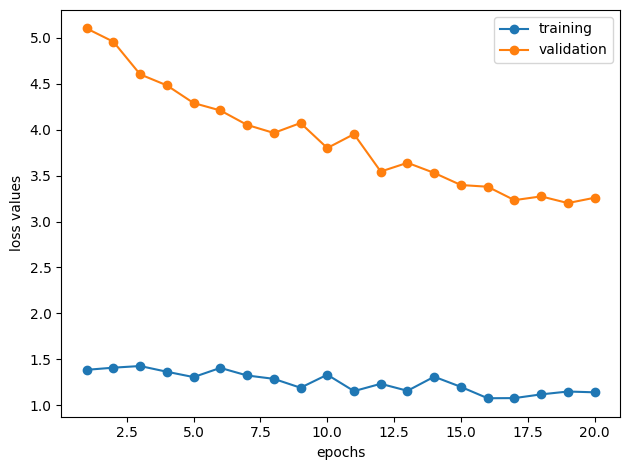

In [ ]:
plot_losses(avg_train_losses_zh, avg_valid_losses_zh)

## Evaluating the model

Implement the baseline decoding method that generate the tokens greedily.

In [ ]:
def predict(encoder, decoder, sentence, src_sp, tgt_sp):
    with torch.no_grad():
        input_tensor = [[src_sp.bos_id()] + src_sp.encode_as_ids(sentence) + [src_sp.eos_id()]]
        input_tensor = torch.tensor(input_tensor, device=device)

        encoder_output, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[tgt_sp.bos_id()]], device=device)
        decoder_hidden = encoder_hidden

        decoded_ids = []

        for di in range(MAX_LENGTH):
            # TO-DO: generate next output and hidden state from decoder_input and decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, encoder_hidden)

            # TO-DO: get the id of the most likely item from decoder_output
            _, topi = decoder_output.data.topk(1,  dim=-1)
            if topi.item() == tgt_sp.eos_id():
                break
            else:
                decoded_ids.append(topi.item())

            decoder_input = topi.squeeze(-1).detach()
        # TO-DO: use the Sentencepiece model to convert the ids back to a string
        decoded_words = tgt_sp.decode(decoder_input)

        return decoded_words

Bonus points (20%): implement beam search. This is optional.

To make autograding work, your beam_search should return a list of predictions from the most likely to the least likely, and each prediction should be a tuple of (score, text). For example:

```
[(0,2, "Thank you"), (0.1, "Thanks"), (0.01, "Thanks you")]
```

In [ ]:
def beam_search(encoder, decoder, sentence, src_sp, tgt_sp, beam_size=5):
    assert beam_size > 1, "if beam_size = 1, then that's greedy search"
    with torch.no_grad():
        # TO-DO: Just like predict() but instead of the topk with 1, take topk with beam_size and rank sort the beam for the more likely probability
        raise NotImplemented

Try out a random input. 

1. Does the output make sense if given an input from the training set?
2. Does the output make sense if given an arbitrary input?

In [ ]:
# reload the encoder and decoder if necessary
encoder_eng_zh = torch.load('en_zh_encoder.pt')
decoder_eng_zh = torch.load('en_zh_decoder.pt')

In [ ]:
print(
    predict(
        encoder_eng_zh,
        decoder_eng_zh,
        "What gives us the courage?",
        en_sp,
        zh_sp,
    )
)

RuntimeError: ignored

In [ ]:
print(
    beam_search(
        encoder_eng_zh,
        decoder_eng_zh,
        "What gives us the courage?",
        en_sp,
        zh_sp,
        beam_size=5,
    )
)

Define a function to generate model predictions and save them in a file. Download your model predictions.

In [ ]:
def generate_and_save(valid_inputs, encoder, decoder, src_sp, tgt_sp, beam_size=1, saveloc="preds.zh"):
    generated_sents = []
    for src_sent in tqdm(valid_inputs):
        if beam_size <= 1:
            tgt_sent = predict(encoder, decoder, src_sent, src_sp, tgt_sp)
        else:
            # change this if your beam search returns something different
            tgt_sent = beam_search(encoder, decoder, src_sent, src_sp, tgt_sp, beam_size)[0][1]
        # if the decoded string is empty, we replace it with the Sentencepiece unk character
        if len(tgt_sent) == 0:
            tgt_sent = "⁇"
        generated_sents.append(tgt_sent)
    with open(saveloc, "w") as fout:
        fout.write("\n".join(generated_sents))
    return generated_sents

### Checkpoint 4

Calculate BLEU and CHRF scores.

In [ ]:
with open("valid.zh") as fin:
    refs = fin.read().strip().split("\n")

In [ ]:
preds = generate_and_save(valid_data["en"], encoder_eng_zh, decoder_eng_zh, en_sp, zh_sp, saveloc="valid_preds.zh")

The BLEU score will be very low for the baseline model.

In [ ]:
bleu = BLEU(tokenize="flores101")
print(bleu.corpus_score(preds, refs))

You should get at least 25 CHRF score.

In [ ]:
chrf = CHRF()
print(chrf.corpus_score(preds, refs))